### 1 - Definição do problema

Doenças cardiovasculares são a causa número 1 de mortes num contexto global. Representando 31% do total de mortes anuais
mundialmente.

Individuos que sofrem de doença cardiovascular ou estão em risco de sofrer (devido à presença de um ou mais fatores,
considerados de risco, como, hipertensão, diabetes, hiperlipidemia ou devido a outra doença), beneficiam de uma prematura
deteção e gestão para minimizar o risco de um agravamento de sintomas ou até manisfestação da doença.

Assim, é importante analisar dados clinicos de atuais pacientes e individous já considerados de risco, de maneira a
poder-se melhorar a capacidade de deteção de indícios da manisfestação da doença, por forma de melhor evitá-la ou pelo
menos mitigar os seus efeitos.

Com estes dados pretende-se analisar possiveis causas e padrões que conduzem ou representam fatores que podem induzir
a ocorrência de doenças cardiovasculares.

### 2 - Aquisição dos dados
Os dados utilizados para este trabalho foram retirados do Kaggle em https://www.kaggle.com/fedesoriano/heart-failure-prediction
e representam um agregado de conjuntos de dados clínicos de pacientes das seguintes instituições:

* Cleveland: 303 observations
* Hungarian: 294 observations
* Switzerland: 123 observations
* Long Beach VA: 200 observations
* Stalog (Heart) Data Set: 270 observations

E fornecidos por:

1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

Estes dados já tinham sido anteriormente ligeiramente preparados, isto, é, já tinha sido feito uma remoção prévia de
dados duplicados.


## 3 - Data Wrangling

Nesta etapa as seguintes tarefas vão ser realizadas:
- Importar o dataset e fazer a limpeza de valores NaN (vazios)
- Renomear algumas colunas para melhor compreensão dos dados
- Converter nomenclaturas/abreviações para melhor processamento de dados
- Criar novas colunas de categorias para agrupar os diferentes individuos, segundo, fatores de risco

Importar as bibliotecas que vão ser utilizadas

In [323]:
import numpy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from upsetplot import plot
import seaborn as sns
from math import ceil
sns.set()

Machine Learning algorithms

In [324]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier  # Random Forest
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, \
    cross_val_score  # training and testing data split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # for confusion matrix
from sklearn.preprocessing import LabelEncoder

Importar o dataset

In [325]:
df = pd.read_csv('../data/heart.csv', sep=",", encoding="utf-8")
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [326]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [327]:
df.drop_duplicates()
df.shape

(918, 12)

The dataset doesn't contain any nulls by default or duplicated values.

Vamos renomear algumas colunas para tornar os dados mais perceptiveis.

In [328]:
df = df.rename(columns={'Sex': 'Gender', 'FastingBS': 'Diabetes', 'MaxHR': 'MaxHeartRate', 'Oldpeak': 'STDeviation',})

In [329]:
# numeric value columns
metric_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHeartRate', 'STDeviation']

Analise das colunas não númericas.

In [330]:
categorical = ["Gender", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

for value in categorical:
    print(df[value].value_counts(normalize=True), "\n")

M    0.78976
F    0.21024
Name: Gender, dtype: float64 

ASY    0.540305
NAP    0.221133
ATA    0.188453
TA     0.050109
Name: ChestPainType, dtype: float64 

Normal    0.601307
LVH       0.204793
ST        0.193900
Name: RestingECG, dtype: float64 

N    0.595861
Y    0.404139
Name: ExerciseAngina, dtype: float64 

Flat    0.501089
Up      0.430283
Down    0.068627
Name: ST_Slope, dtype: float64 



### Transformações de variaveis

Uma vez que algumas colunas apresentam valores categoricos, estes podem ser convertidos em valores númericos para
facilitar o seu processamento.

In [331]:
enc = LabelEncoder()

# Gender: M -> 1 | F -> 0
enc.fit(df['Gender'])
df['Gender'] = enc.transform(df['Gender'])

# ChestPainType: ASY -> 0 | ATA -> 1 | NAP -> 2 | TA -> 3
enc.fit(df['ChestPainType'])
df['ChestPainType'] = enc.transform(df['ChestPainType'])

# RestingECG: LVH -> 0 | Normal -> 1 | ST -> 2
enc.fit(df['RestingECG'])
df['RestingECG'] = enc.transform(df['RestingECG'])

# ExerciseAngina: N -> 0 | Y -> 1
enc.fit(df['ExerciseAngina'])
df['ExerciseAngina'] = enc.transform(df['ExerciseAngina'])

# ST_Slope: Down -> 0 | Flat -> 1 | Up -> 2
enc.fit(df['ST_Slope'])
df['ST_Slope'] = enc.transform(df['ST_Slope'])

df

,Age,Gender,ChestPainType,RestingBP,Cholesterol,Diabetes,RestingECG,MaxHeartRate,ExerciseAngina,STDeviation,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,0,144,193,1,1,141,0,3.4,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


##### Faixas etárias

Vamos categorizar as idades dos individuos no dataset, agrupando-os por faixas etárias
para melhor analisar os resultados dos dados clínicos destes.

In [332]:
df_extra_info = df.copy()
bins = np.arange(20, 100, 15)

df['AgeClass'] = np.digitize(df['Age'], bins, right=True)

Função génerica classificadora de dados como sendo altos, baixos ou normais.

Assim vai ser criada uma coluna onde os niveis de cada panciente estão classificados entre 'low', 'normal' e 'high'.


In [333]:
def f(row,col_name, min_value, high_value):
    if row[col_name] < min_value:
        val = 'Low'
    elif min_value < row[col_name] <= high_value:
        val = 'Normal'
    else:
        val = 'High'
    return val

##### Niveis de colestrol

O nivel de colestrol total para um adulto normal varia entre 125 a 200 mg/dL.

In [334]:
df['CholesterolClass'] = df.apply(lambda row: f(row,'Cholesterol', 125, 200) , axis=1)

##### Niveis pressão sanguinea em repouso

O nivel de pressão sanguinea para um adulto normal varia entre 90/60mmHg e 120/80mmHg. Sendo considerada elevada quando
ultrapassa os 140/90mmHg.

In [335]:
df['RestingBPClass'] = df.apply(lambda row: f(row,'RestingBP', 90, 140) , axis=1)

##### Niveis máximos de batimentos cardiacos

Segundo, https://www.drjohnm.org/2011/08/whats-a-normal-heart-rate/
os niveis de batimentos cardiacos podem variar muito, pois estes são influenciados por diferentes fatores, como fatores
genéticos, hormonais, idade, historico de saúde, etc.

Para simplificação foi considerado que para um adulto normal, irião ser assumidos como um niveís normaais entre os
60 e os 100 batimentos/minuto.

In [336]:
df['MaxHeartRateClass'] = df.apply(lambda row: f(row,'MaxHeartRate', 90, 140) , axis=1)

Data set final após Data Wrangling.

In [337]:
df

,Age,Gender,ChestPainType,RestingBP,Cholesterol,Diabetes,RestingECG,MaxHeartRate,ExerciseAngina,STDeviation,ST_Slope,HeartDisease,AgeClass,CholesterolClass,RestingBPClass,MaxHeartRateClass
0,40,1,1,140,289,0,1,172,0,0.0,2,0,2,High,Normal,High
1,49,0,2,160,180,0,1,156,0,1.0,1,1,2,Normal,High,High
2,37,1,1,130,283,0,2,98,0,0.0,2,0,2,High,Normal,Normal
3,48,0,0,138,214,0,1,108,1,1.5,1,1,2,High,Normal,Normal
4,54,1,2,150,195,0,1,122,0,0.0,2,0,3,Normal,High,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1,2,High,Normal,Normal
914,68,1,0,144,193,1,1,141,0,3.4,1,1,4,Normal,High,High
915,57,1,0,130,131,0,1,115,1,1.2,1,1,3,Normal,Normal,Normal
916,57,0,1,130,236,0,0,174,0,0.0,1,1,3,High,Normal,High


## 4 - EDA

O EDA vai estar divido em três secções:
- Compreensão dos dados clínicos
- Análise de valores a 0
- Visualização de dados
- Outliers
- Análise por grupos de dados

### Compriender os dados

#### restingECG
O ECG deteta os sinais elétricos do coração, uma vez que cada contração do músculo cardíaco ou das válvulas cardíacas
emite um impulso, este exame mede o tempo e a força dos impulsos elétricos.

Este teste pode ser feito de duas maneiras, em repouso (resting) ou em esforço/stress e providencia informação sobre o
batimento cardiaco e ritmo, podendo demonstrar se existe aumento do coração devido a uma elevada pressão sanguinea.

Por esse motivo, é o exame indicado para o despiste de arritmias cardíacas ou para a deteção
precoce de indicadores de isquemia cardíaca.

De notar que um resultado “normal” neste exame, não é suficiente para excluir uma doença
cardiovascular.

Nestes dados aparece como
* Normal
* ST - tendo onda ST segmentation anormal (T wave inversions and/or ST elevation or depression of > 0.05 mV)
* LVH (left ventricular hipertrophy)

A presença de ST segmentation num ECG, deve-se a uma quebra no fluxo da corrente no grandiente de zonas isquémicas e
não-isquémicas, que afeta o fase de plateau, isto é, do potencial de ação transmembrana ventricular e por conseguinte
causa o ST segment.


#### ST Slope
Segundo, https://www.ncbi.nlm.nih.gov/books/NBK459364/
ST Slope or ST Segmentation é uma importante componente de um ECG e é, a forma que este pode tomar
acima (ST elevation) ou abaixo (ST depression) da linha de referência. Para além disso é importante caracterizar a
forma da onda do ST segment, pois este pode ser classificado como horizontal (flat), upsloping, ou downsloping
(sendo os últimos dois rápidos ou lentos) que são os dados presentes nesta
coluna.

Implicações destes fatores:
* A presença de uma ST elevation é uma causa comum para a deteção de fatores como LVH
* Em geral uma isquemia cardíaca é representada por uma ST depression, enquanto que uma lesão cardiáca pode ser indicada
por uma ST elevation
* É preciso ter em conta que nem todas as ST elevations ou ST depression representam isquemia cardíaca ou condições
emergentes, contudo multiplas condições estão associadas a estes fatores.

#### STDeviation

Está relacionada com a ocorrência de uma ST depression, representando as mudanças das ondas T, onde tanto para homens
como para mulheres os valores de referência são de -0.05 mV em V e -0.1 mV em todas as restantes.

Segundo, https://ecgwaves.com/st-segment-normal-abnormal-depression-elevation-causes/
para quantificar as variações dos ST segments, calcula-se a variação em milimetros até ao ponto J da onda do ECG.

Assim, assume-se que os valores desta coluna, são dados em milemetros (mm) e que como está associada aos valores da
ST depression, valores, negativos, referem-se a medições de uma ST elevation.


#### ExerciseAngina

Angina é a dor que pode ocorrer durante a prática de exercício fisíco, stress ou outras coisas semelhantes que façam o
o coração trabalhar em esforço.

É um sintóma comum para doença na artéria coronária que pode ser causada artérias coronárias bloqueadas por colestrol.

#### Diabetes
É um indicador obtido através da colheita de sangue em jejum, feito normalmente, durante a noite.
Um nível inferior a 100 mg/dl é considerado normal, entre 100 e 125 mg/dl é indicador de pré-diabetes e acima disso
o paciente tem diabetes (geralmente fazem-se 2 testes diferentes para confirmar os resultos).

Neste dataset, estes valores são distinguidos entre ter diabetes (1) e não ter diabetes (0), ou seja, pacientes marcados
com “1” tinham valores acima de 120 mg/dl.


### Análise de valores a 0

In [338]:
df['Cholesterol'].value_counts(normalize=True)

0      0.187364
254    0.011983
223    0.010893
220    0.010893
230    0.009804
         ...   
392    0.001089
316    0.001089
153    0.001089
466    0.001089
131    0.001089
Name: Cholesterol, Length: 222, dtype: float64

Verifica-se que existem 172 pacientes com valor 0, o que em termos médicos não faria sentido registarem estes valores.

Uma vez que 172 pacientes representam 18% do dataset, a sua remoção poderia ter impactos negativos em futuras
análises. Assim ao invés de serem removidos optou-se por substituir estes valores pela mediana da coluna em questão.

In [339]:
df['Cholesterol'] = df['Cholesterol'].apply(lambda x: df['Cholesterol'].median() if x < 75 else x)
df['CholesterolClass'] = df.apply(lambda row: f(row,'Cholesterol', 125, 200) , axis=1)

### Visualização de dados

#### histograms

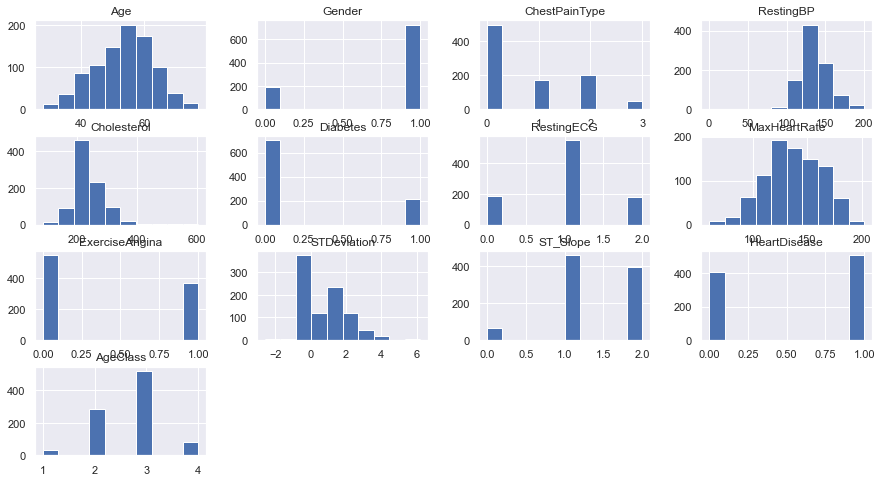

In [340]:
df.hist()
plt.show()

#### Heatmaps

<AxesSubplot:>

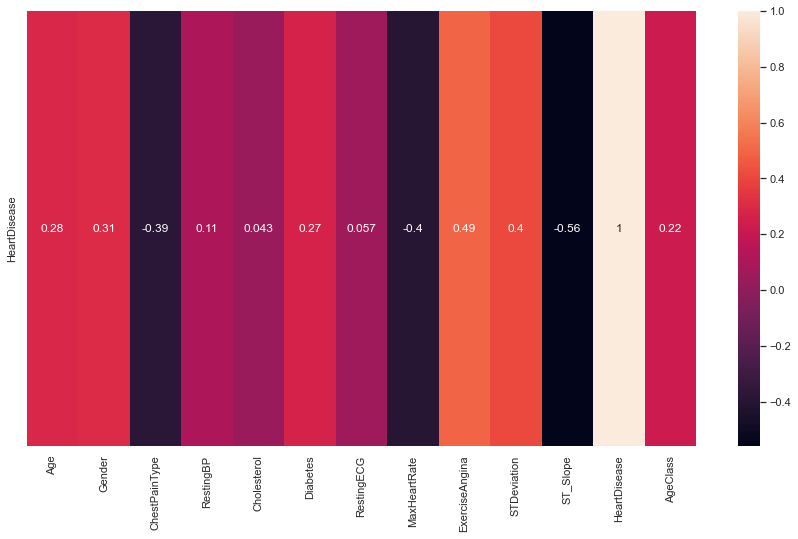

In [341]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(data=df.corr().loc[['HeartDisease']], annot=True)

<AxesSubplot:>

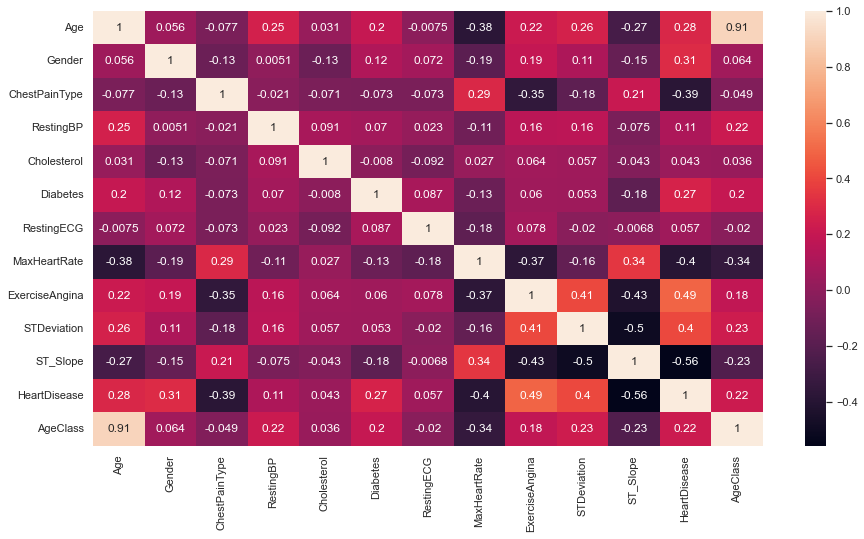

In [342]:
sns.heatmap(data=df.corr(), annot=True)

Parece que os dados não se correlacionam diretamente, apenas destacando-se uma ligeira correlação entre doenças de
coração e Angina durante exercício

#### Outliers

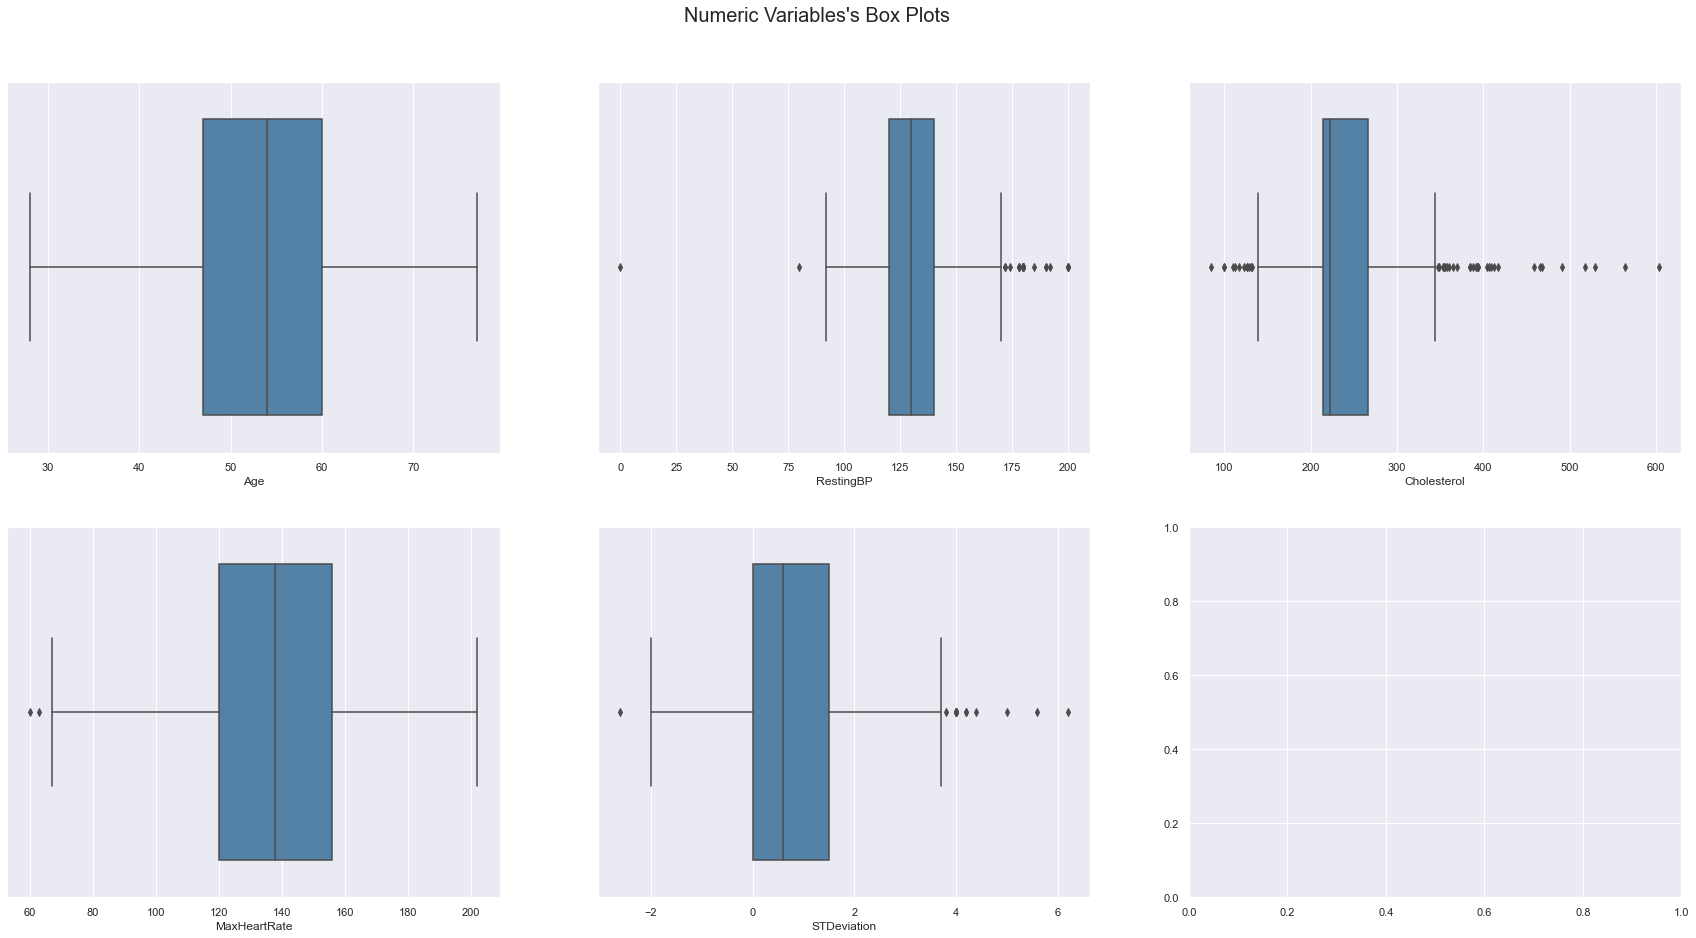

In [343]:
sns.set()
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(30, 15))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df[feat], ax=ax, color='steelblue')

title = "Numeric Variables's Box Plots"
plt.suptitle(title, y=0.95, fontsize=20)
plt.show()

#### Outliers

In [344]:
outliers_filter = ( ((100 < df['Cholesterol']) & (df['Cholesterol'] < 350))
                    & ((75 < df['RestingBP']) & (df['RestingBP'] < 175))
                    & (df['STDeviation'] < 4))
df_no_outliers = df[outliers_filter].copy()
df_no_outliers.shape

(854, 16)

In [345]:
print('Percentage of data kept after removing outliers:', np.round(df_no_outliers.shape[0] / df.shape[0], 4)*100, '%')
print('Percentage of data removed:', np.round((1-(df_no_outliers.shape[0] / df.shape[0]))*100, 4), '%')

df = df_no_outliers

Percentage of data kept after removing outliers: 93.03 %
Percentage of data removed: 6.9717 %


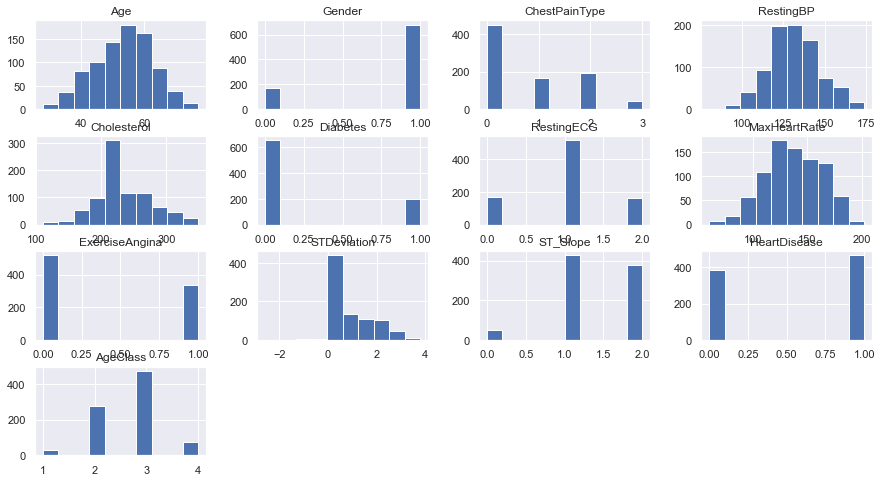

In [346]:

df.hist()
plt.show()

Verifica-se a existência de alguns outliers nas variaveis numéricas, como, por exemplo, nos dados da pressão sanguinea
e niveis de colestrol, contudo, a existência destes “outliars” pode estar correlacionada com a presença
de doença do coração, isto é, pode ser um fator que contribui para esta se manifestar.

Assim, apenas outliears que representavam dados irrealistas de acordo com o significado clinico da variável,
foram removidos.

### Análise por grupos de dados - Sobre ter doença cardiovascular

#### Distribuição por género

In [347]:
df['Gender'].value_counts(normalize=True)

1    0.796253
0    0.203747
Name: Gender, dtype: float64

Verifica-se que aproximadamente 4 em 5 individous neste conjunto de dados são homems

##### Distribuição por idades

<AxesSubplot:>

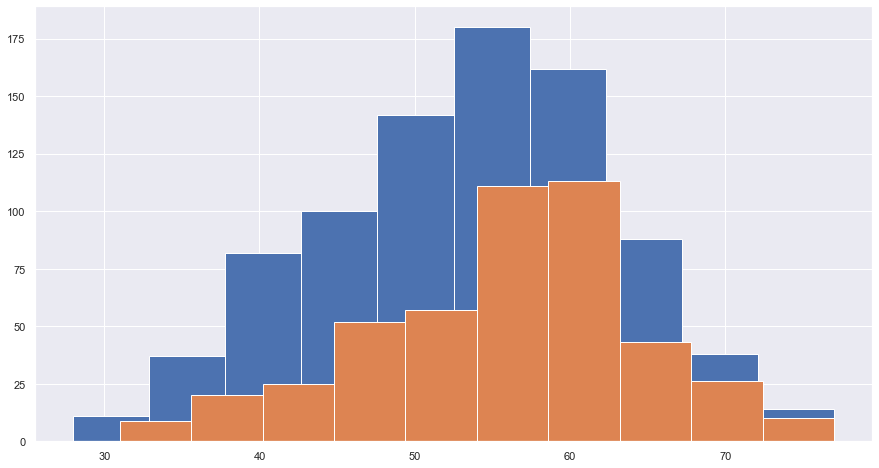

In [348]:
df_heart_disease = df[df.HeartDisease.apply(lambda x: x == 1)]
df['Age'].hist()
df_heart_disease['Age'].hist()

Ao analisar a distribuição de idades constata-se que a maior parte dos individuos tem entre 50 e 65 anos.

Ao comparar-se a distribuição das idades com as idades em que individuos sofrem de
doenças do coração verifica-se que esta é mais comum na faixa etária entre os 55 e 65 anos

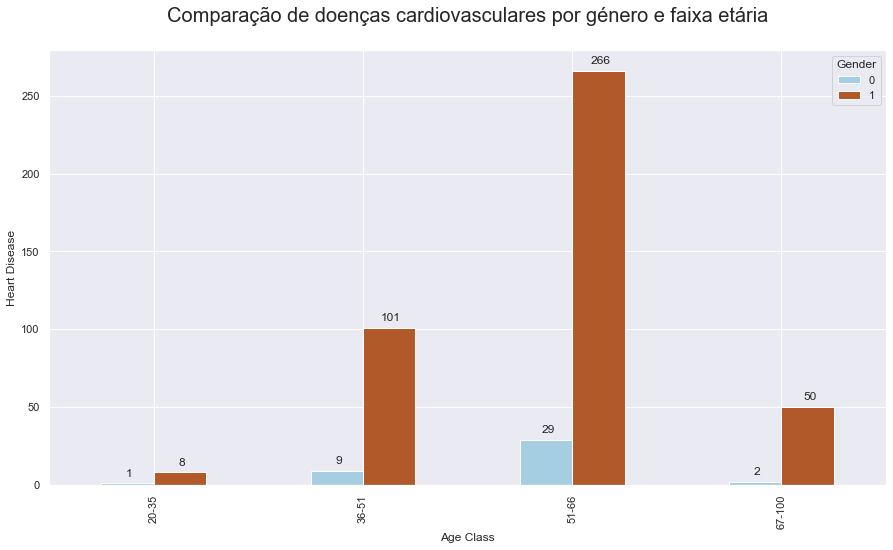

In [349]:
counts = df_heart_disease.groupby(['AgeClass', 'Gender']).Age.count().unstack()

ax = counts.plot(kind='bar',stacked = False, colormap = 'Paired')

for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=0).astype(np.int64), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(2, 10), textcoords='offset points')

ax.set_xticklabels(['20-35','36-51','51-66','67-100'])
plt.xlabel ('Age Class')
plt.ylabel ('Heart Disease')
plt.title('Comparação de doenças cardiovasculares por género e faixa etária\n',fontsize=20)
plt.show()

Filtrando os dados por individuos apenas com doença de coração, e tendo em conta a desproporção do género neste dataset
verifica-se que homems entre os 51 e os 66 anos sofrem ligeiramente mais com esta doença.

##### Dores no peito

Dores no peito quando a praticar exercício físico, sob stress ou até em repouso são dos principais motivadores que levam
individuos a procurar ajuda médica para despistar possiveis problemas, assim é importante ver a relação que estes
indicadores podem ter na possibilidade de existir um problema mais sério.

In [350]:

# ChestPainType: ASY -> 0 | ATA -> 1 | NAP -> 2 | TA -> 3
# ExerciseAngina: N -> 0 | Y -> 1

df_with_pain = (df['ChestPainType'] > 0)
df_pain_exercising = (df['ExerciseAngina'] == 1)

In [351]:
df[df_pain_exercising]['HeartDisease'].value_counts(normalize=True)

1    0.85119
0    0.14881
Name: HeartDisease, dtype: float64

In [352]:
df[df_pain_exercising & df_with_pain]['HeartDisease'].value_counts(normalize=True)

1    0.657143
0    0.342857
Name: HeartDisease, dtype: float64

In [353]:
print(df[df_with_pain]['ExerciseAngina'].value_counts(normalize=True), '\n')
print(df[df_pain_exercising]['ChestPainType'].value_counts(normalize=True))

0    0.826733
1    0.173267
Name: ExerciseAngina, dtype: float64 

0    0.791667
2    0.145833
1    0.044643
3    0.017857
Name: ChestPainType, dtype: float64


Verifica-se que 85% dos pacientes que reportam dores ao fazer exercício sofrem de doenças cardiovasculares, mas
pacientes que reportam essas dores e dores no peito no geral, apenas 65% tem doenças cardiovasculares.

Assim, dores no peito ao fazer exercício tem uma grande correlação com ter doenças cardiovasculares, já a
presença de dores no peito e dores ao fazer exercício não demonstrou ter correlação alguma.

#### Dados clínicos de despiste

Antes de se recorrer a procedimentos mais invasivos, apurar o nível de **colestrol**, **pressão sanguinea**,
**açucar no sangue** ou até fazer um eletrocardiograma (ECG), são os passos mais comuns para uma análise geral do quadro clínico do paciente.

In [354]:
high_cholesterol = df['CholesterolClass'] == "High"
high_BP = df['RestingBPClass'] == "High"
has_diabetes = df['Diabetes'] == 1

df_1 = df[high_cholesterol & high_BP]
print(df_1['HeartDisease'].value_counts(normalize=True), '\n')

print(df[high_cholesterol & high_BP & has_diabetes].shape)

1    0.728477
0    0.271523
Name: HeartDisease, dtype: float64 

(48, 16)


In [355]:
df[high_cholesterol & high_BP & has_diabetes]['HeartDisease'].value_counts(normalize=True)

1    0.854167
0    0.145833
Name: HeartDisease, dtype: float64

Aqui é possivel ver que 85% dos pacientes que apresentam uma combinação de colestrol, pressão sanguinea e diabetes têm
doenças cardiovasculares. Que são todos indices que se sabe, que contribuem para que este tipo de doenças ocorram, uma
vez que demonstram que o sistema cardiovascular de um individuo se encontra sobre carregado e em esforço.

#### Dores no peito e niveis de risco de dados clínicos

Uma vez que dores no peito durante o exercício apresenta grande correlação com a existência de doenças cardiovasculares
tal como niveis de risco de dados clínicos, é interessante ver se pacientes com estes dados de risco, reportaram as
dores no peito.

In [356]:
print(df[high_cholesterol & high_BP & has_diabetes]['ExerciseAngina'].value_counts(normalize=True))

print(df[high_cholesterol & high_BP & has_diabetes & df_pain_exercising]['HeartDisease'].value_counts(normalize=True))

1    0.583333
0    0.416667
Name: ExerciseAngina, dtype: float64
1    0.928571
0    0.071429
Name: HeartDisease, dtype: float64


Como esperado 58% dos pacientes com niveis de risco apresenta dores no peito ao exercitar-se e 93% desses sofre de
doenças cardiovasculares


#### Eletrocardiograma (ECG)

Contudo nem sempre os indicadores são assim tão assim tão expressiveis, e os médicos podem ter necessidade de recorrer a
um eletrocardiograma (ECG) para despistar problemas.

In [357]:
# RestingECG: LVH -> 0 | Normal -> 1 | ST -> 2
normal_ecg = df['RestingECG'] == 1
st_ecg = df['RestingECG'] == 2
lvh_ecg = df['RestingECG'] == 0

print(df[normal_ecg]['HeartDisease'].value_counts(normalize=True), '\n')
print(df[lvh_ecg]['HeartDisease'].value_counts(normalize=True), '\n')
print(df[st_ecg]['HeartDisease'].value_counts(normalize=True))

1    0.506744
0    0.493256
Name: HeartDisease, dtype: float64 

1    0.563953
0    0.436047
Name: HeartDisease, dtype: float64 

1    0.650307
0    0.349693
Name: HeartDisease, dtype: float64


<AxesSubplot:>

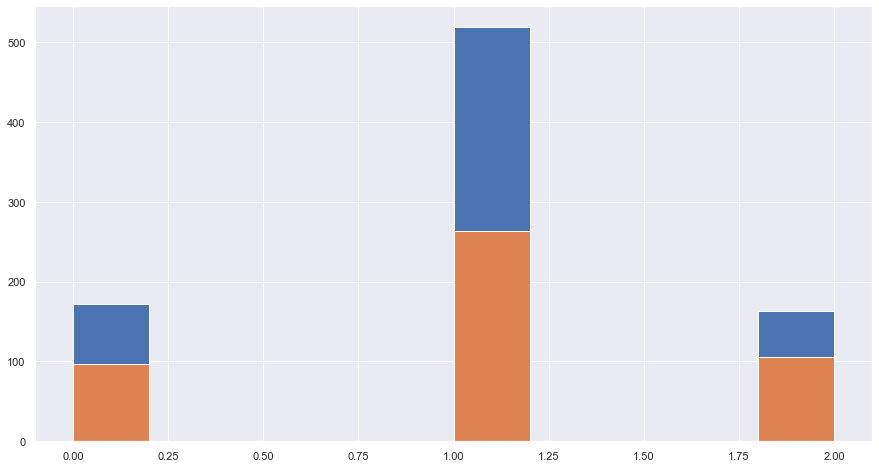

In [358]:
df['RestingECG'].hist()
df_heart_disease['RestingECG'].hist()

Parece que um eletrocardiograma com resultado "normal" não é uma segurança de que o paciente está livre de problemas,
contudo também não garante o contrário.

In [359]:
# ST_Slope: Down -> 0 | Flat -> 1 | Up -> 2
up_slope = df['ST_Slope'] == 2
down_slope = df['ST_Slope'] == 0
st_deviation_down = df['STDeviation'] > 0

print(df[down_slope & st_deviation_down]['HeartDisease'].value_counts())

1    37
0    11
Name: HeartDisease, dtype: int64


<AxesSubplot:>

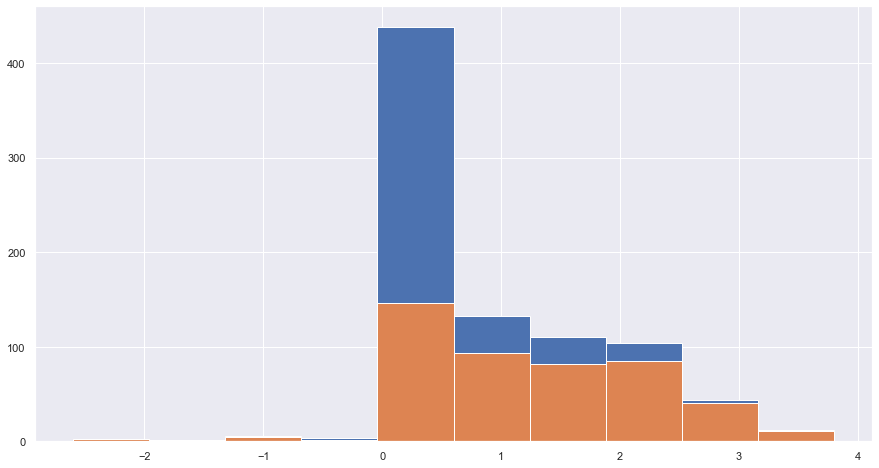

In [360]:
df['STDeviation'].hist()
df_heart_disease['STDeviation'].hist()

Parece que quanto maior a acentuação dos declives durante um ECG maior a probabilidade ter doença cardiovascular.

#### ST elevation in man and women

<AxesSubplot:>

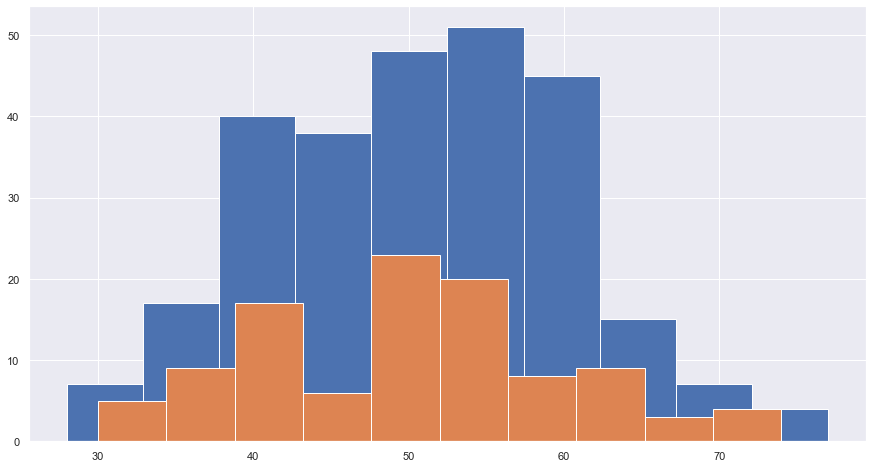

In [361]:
# Gender: M -> 1 | F -> 0
df[up_slope & (df['Gender'] == 1)]['Age'].hist()
df[up_slope & (df['Gender'] == 0)]['Age'].hist()

Segundo, https://www.ncbi.nlm.nih.gov/books/NBK459364/,
ST elevation parecer ser mais predominante em homems jovens e adultos de meia-idade em relação
às mulheres e segundo o gráfico a cima os dados confirmam estas afirmações.


#### Max hear rate

<AxesSubplot:>

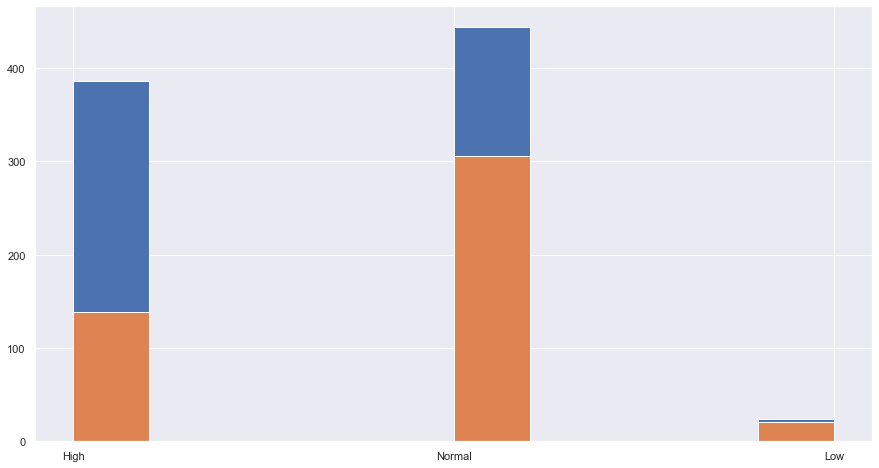

In [362]:
df['MaxHeartRateClass'].hist()
df_heart_disease['MaxHeartRateClass'].hist()

Como esperado o batimento cardiaco que é uma variavel cuja interpretação pode ter diferentes classificações, dependedo do
individuo, uma vez que vários fatores podem contribuir. Esta não demonstra grande relação direta com um individuo vir a
sofrer de doença cardiovascular.

## Machine learning

In [363]:
df['HeartDisease'].value_counts(normalize=True)

1    0.545667
0    0.454333
Name: HeartDisease, dtype: float64

O dataset aparenta ser quase balanceado neste aspeto, uma vez que existem quase tantos casos com
doença de coração como sem.

### Model Pipeline

### Estabelecer valores de referência para os algoritmos

In [364]:
num_folds = 10
seed = 7
scoring = 'accuracy'

#### Separação dos dados

In [365]:
inputs = df.drop(['HeartDisease', 'CholesterolClass', 'RestingBPClass', 'MaxHeartRateClass', 'AgeClass'], axis=1)
targets = df['HeartDisease']

validation_size = 0.70
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(inputs, targets, test_size=validation_size, random_state=seed)

#### Definição de algoritmos a usar

In [366]:
# Spot Check Algorithms
models = [('LR', LogisticRegression(solver='lbfgs')), ('LDA', LinearDiscriminantAnalysis()),
          ('KNN', KNeighborsClassifier()), ('CART', DecisionTreeClassifier()), ('NB', GaussianNB()),
          ('SVM', SVC(gamma='scale'))]

Os algoritmos estão no seu estado base, vai ser analizado o comportamento que cada uma tem com os dados
em questão.

In [367]:
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=num_folds)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

/Users/migueloliveira/.conda/envs/fcdProject/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/migueloliveira/.conda/envs/fcdProject/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

LR: 0.840308 (0.052003)
LDA: 0.836308 (0.062315)
KNN: 0.687385 (0.058820)
CART: 0.757692 (0.067599)
NB: 0.844000 (0.071826)
SVM: 0.711077 (0.045803)


#### Comparação de algoritmos

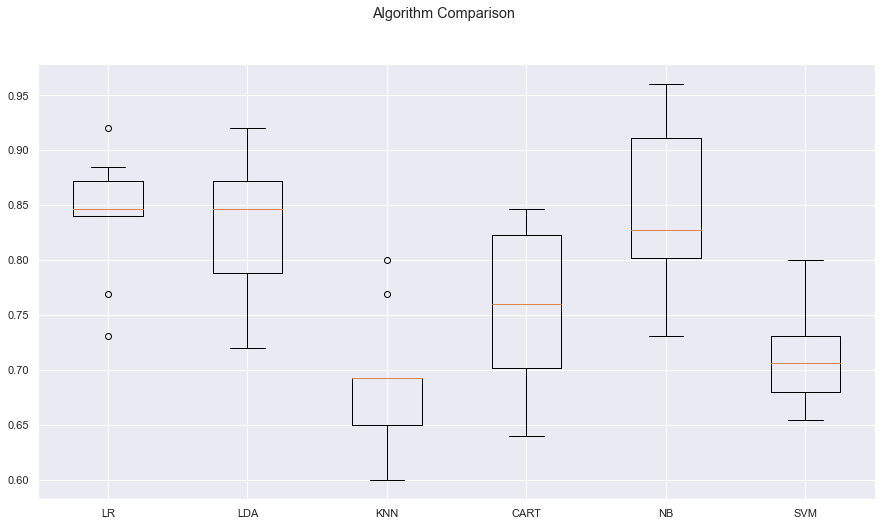

In [368]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Normalização dos dados

In [369]:
# Standardize the Dataset
pipelines = [('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression(solver='lbfgs'))])),
             ('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])),
             ('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])),
             ('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])),
             ('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])),
             ('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC(gamma='scale'))]))]

results = []
names = []
for name, model in pipelines:
	kfold = KFold(n_splits=num_folds)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

ScaledLR: 0.840462 (0.057523)
ScaledLDA: 0.836308 (0.062315)
ScaledKNN: 0.839846 (0.053914)
ScaledCART: 0.781077 (0.058571)
ScaledNB: 0.844000 (0.071826)
ScaledSVM: 0.856000 (0.051142)


É possivel confirmar que o melhor resultado anteriormente obtido era do Naives Bayes, mas que este ficou inalterado,
contudo, nota-se a grande melhoria para os algoritmos LogisticRegression e SVM, tendo o último obtido o melhor resultado
de todos.

#### Comparação de resultados

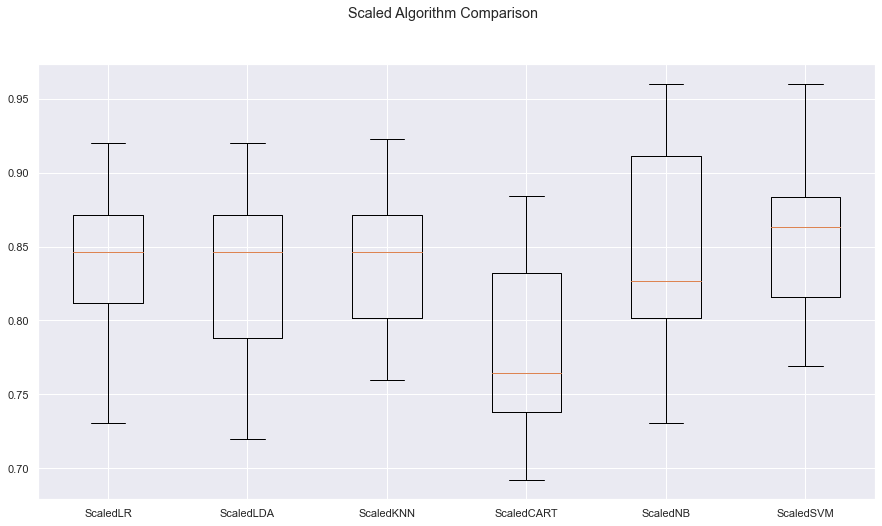

In [370]:
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Visto que o SVM consegui-o o melhor resultado foi selecionado para otimização.

#### Tuning SVM

In [371]:
# Tune scaled SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC(gamma='scale')
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.863846 using {'C': 0.7, 'kernel': 'rbf'}
0.844154 (0.051095) with: {'C': 0.1, 'kernel': 'linear'}
0.734923 (0.118214) with: {'C': 0.1, 'kernel': 'poly'}
0.824615 (0.071471) with: {'C': 0.1, 'kernel': 'rbf'}
0.824769 (0.057257) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.852000 (0.047152) with: {'C': 0.3, 'kernel': 'linear'}
0.832308 (0.057106) with: {'C': 0.3, 'kernel': 'poly'}
0.844154 (0.061792) with: {'C': 0.3, 'kernel': 'rbf'}
0.836615 (0.065466) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.856000 (0.050905) with: {'C': 0.5, 'kernel': 'linear'}
0.840000 (0.047239) with: {'C': 0.5, 'kernel': 'poly'}
0.848154 (0.064999) with: {'C': 0.5, 'kernel': 'rbf'}
0.848154 (0.057978) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.856000 (0.050905) with: {'C': 0.7, 'kernel': 'linear'}
0.840000 (0.047239) with: {'C': 0.7, 'kernel': 'poly'}
0.863846 (0.054350) with: {'C': 0.7, 'kernel': 'rbf'}
0.840462 (0.060240) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.852154 (0.050044) with: {'C': 0.9, 'kernel': 'linear'

Verifica-se que a configuração mais precisa para o SVM foi com o kernel RBF e um valor de C de 0.9, conseguindo obter
uma precisão de 85%

### Ensemble Methods
Por outro lado, existem ainda os algoritmos com recurso as metódos de montagem, que vão agora ser analizados.

 * Boosting Methods: AdaBoost (AB) and Gradient Boosting (GBM).

 * Bagging Methods: Random Forests (RFC) and Extra Trees (ET).

Os modelos vão ser testados nas mesmas configurações que os algoritmos anteriores.

In [372]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# ensembles
ensembles = [('AB', AdaBoostClassifier()), ('GBM', GradientBoostingClassifier()),
             ('RFC', RandomForestClassifier(n_estimators=100)), ('ET', ExtraTreesClassifier())]
results = []
names = []
for name, model in ensembles:
	kfold = KFold(n_splits=num_folds)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

AB: 0.828462 (0.045343)
GBM: 0.824000 (0.032243)
RFC: 0.840000 (0.046982)
ET: 0.836000 (0.045337)


É possivel constatar que estas técnicas conseguem obter bons resultados de precisão na casa dos 85% apenas usando as
as suas configurações base.

#### Comparação de algoritmos

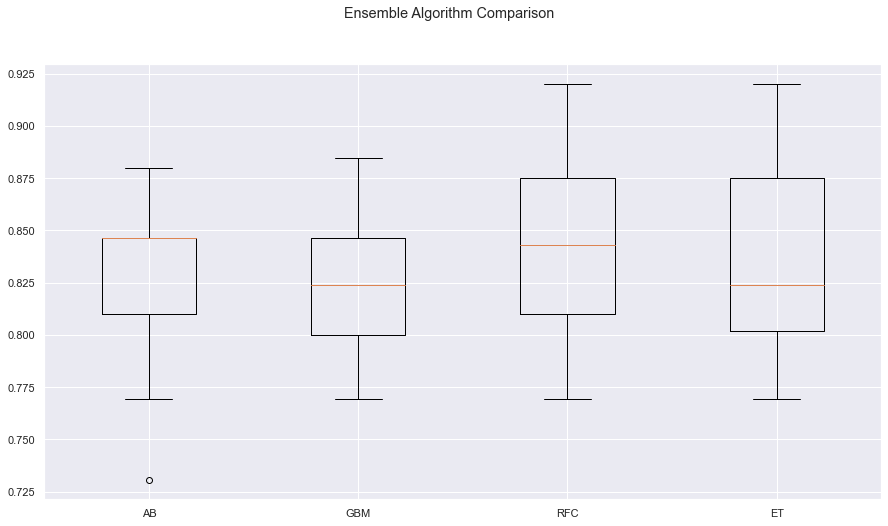

In [373]:
fig = plt.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Os resultados demonstram que o RandomForest apresenta uma ligeira vantagem em relação aos outros e uma tendência de ser
capaz de entrar na casa dos 90s% de precisão.

#### Otimização dos algoritmos de Ensemble

In [374]:
# Tune scaled RFC
scaler = MinMaxScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=numpy.array([50,100,150,200,250,300,350,400]))
model = RandomForestClassifier(random_state=seed)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.843846 using {'n_estimators': 100}
0.840000 (0.053134) with: {'n_estimators': 50}
0.843846 (0.051804) with: {'n_estimators': 100}
0.836000 (0.051451) with: {'n_estimators': 150}
0.836000 (0.056911) with: {'n_estimators': 200}
0.832000 (0.057887) with: {'n_estimators': 250}
0.832000 (0.060588) with: {'n_estimators': 300}
0.828154 (0.058304) with: {'n_estimators': 350}
0.832000 (0.060588) with: {'n_estimators': 400}


Pode-se ver que a melhor configuração para este algoritmo é quando o número de estimadores é de 100 conseguindo
atingir resultados similares, ainda que mais baicos aos da melhor configuração do SVM, mas ainda assim, este apresenta
melhores perspetivas de melhores resultados.


### Finalização do modelo

Tendo em conta os resultados, e devido ao RandomForest conseguir uma ligeira vantagem, demonstra maior possibilidade
de se atingirem melhores resultados com ele.

Agora, o modelo será finalizado, sendo treinado no dataset todo e fará previsões no dataset de validação para confirmar
os resultados.


In [375]:
def runTunedRandoForest(x_train, x_test, y_train, y_test):
    scaler = StandardScaler().fit(x_train)
    rescaledX = scaler.transform(x_train)
    model = RandomForestClassifier(random_state=seed, n_estimators=200)
    model.fit(rescaledX, y_train)

    # transform the validation dataset
    rescaledValidationX = scaler.transform(x_test)
    predictions = model.predict(rescaledValidationX)
    print(accuracy_score(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))

In [376]:
runTunedRandoForest(X_train, X_validation, Y_train, Y_validation)

0.862876254180602
[[219  58]
 [ 24 297]]
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       277
           1       0.84      0.93      0.88       321

    accuracy                           0.86       598
   macro avg       0.87      0.86      0.86       598
weighted avg       0.87      0.86      0.86       598



Por fim conseguiu-se atingir uma precisão de 88% no conjunto de teste total.

Agora que o melhor algoritmo está definido, vai se tentar fazer uma melhor feature selection e ver que resultados se
conseguem obter.

### Improved Feature Selection

#### Chi-square

In [377]:
from sklearn.feature_selection import chi2

X = df.drop(['HeartDisease', 'CholesterolClass', 'RestingBPClass', 'MaxHeartRateClass', 'AgeClass'], axis=1)
X['STDeviation'] = X['STDeviation'].apply(lambda x: 0 if x < 0 else x)
y = df['HeartDisease']

chi_scores = chi2(X,y)
chi_scores

(array([122.680934  ,  17.26274556, 147.13815738,  19.65471177,
         13.13777378,  49.48949439,   0.92375868, 691.59601652,
        126.51012308, 166.93975042,  68.84657148]),
 array([1.63777619e-028, 3.25506656e-005, 7.32030923e-034, 9.27742605e-006,
        2.89401515e-004, 1.99436857e-012, 3.36489998e-001, 2.01011671e-152,
        2.37785678e-029, 3.44818313e-038, 1.06429462e-016]))

<AxesSubplot:>

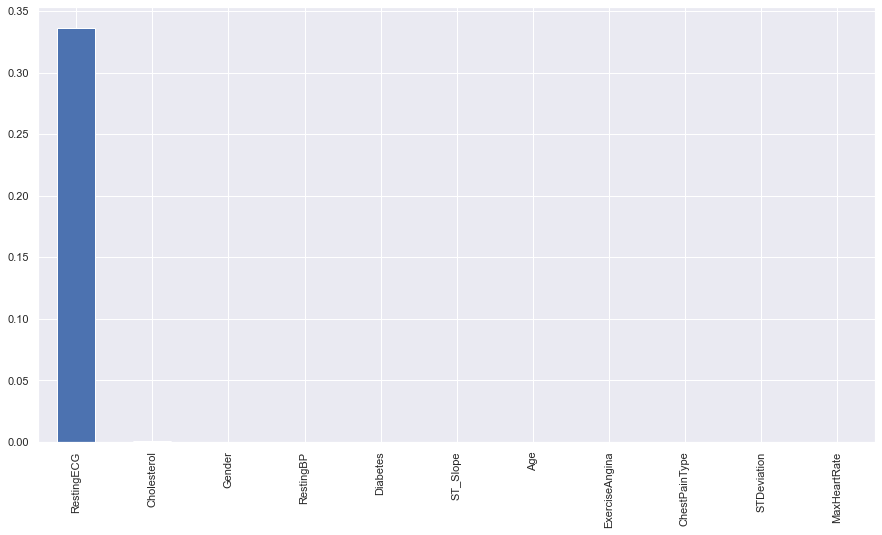

In [378]:
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

Uma vez que a variavel RestingECG tem o maior p-value, isso quer dizer que é uma variavel independente e não deve ser
usada para o modelo de treino.

In [379]:
inputs = df.drop(['HeartDisease', 'CholesterolClass', 'RestingBPClass', 'MaxHeartRateClass', 'AgeClass', 'RestingECG'], axis=1)
targets = df['HeartDisease']

X_train, X_validation, Y_train, Y_validation = train_test_split(inputs, targets, test_size=validation_size, random_state=seed)

runTunedRandoForest(X_train, X_validation, Y_train, Y_validation)

0.8561872909698997
[[215  62]
 [ 24 297]]
              precision    recall  f1-score   support

           0       0.90      0.78      0.83       277
           1       0.83      0.93      0.87       321

    accuracy                           0.86       598
   macro avg       0.86      0.85      0.85       598
weighted avg       0.86      0.86      0.85       598



Tal como esperado com a análise pelo Chi-Square a remoção da variável dos resultados dos ECG não contribui em nada para
o desempenho do modelo, pois sem essa feature o valor da precisão continua nos 86%.

#### Correlações: Pearson and Spearman

<AxesSubplot:>

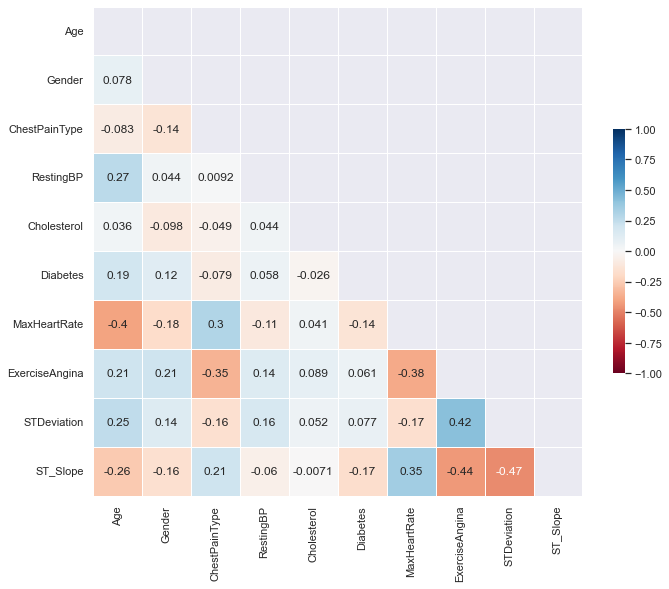

In [380]:
# Compute the correlation matrix - Pearson
corr = inputs.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = 'RdBu', vmax = 1, vmin=-1, center = 0,
            square = True, annot = True, linewidths = .5, cbar_kws = {"shrink": .5})

<AxesSubplot:>

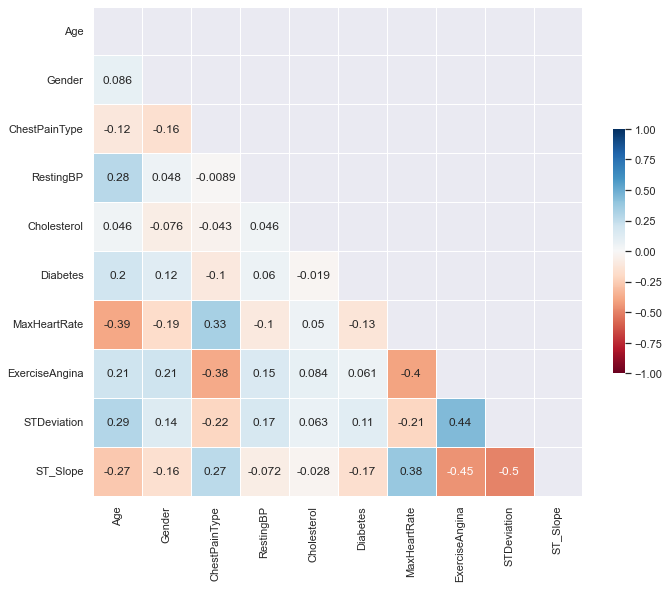

In [381]:
# Compute the correlation matrix - Spearman
corr = inputs.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = 'RdBu', vmax = 1, vmin=-1, center = 0,
            square = True, annot = True, linewidths = .5, cbar_kws = {"shrink": .5})

Vamos aplicar os resultados da analise e ver como se comporta o modelo com a nova seleção de features

In [382]:
inputs = df.drop(['HeartDisease', 'CholesterolClass', 'RestingBPClass', 'MaxHeartRateClass', 'AgeClass',
                  'RestingECG', 'Cholesterol', 'RestingBP'], axis=1)
targets = df['HeartDisease']

X_train, X_validation, Y_train, Y_validation = train_test_split(inputs, targets, test_size=validation_size, random_state=seed)

runTunedRandoForest(X_train, X_validation, Y_train, Y_validation)

0.8545150501672241
[[218  59]
 [ 28 293]]
              precision    recall  f1-score   support

           0       0.89      0.79      0.83       277
           1       0.83      0.91      0.87       321

    accuracy                           0.85       598
   macro avg       0.86      0.85      0.85       598
weighted avg       0.86      0.85      0.85       598



Olhando para o fator correlação em valroes absolutos não se consegue encontrar correlações significativas entre os dados
contudo, numa perspectiva contrário, é possivel verificar que os niveis de colestrol e pressão sanguinea não parecem ter
grande efeito na manifestação de doenças cardiacas, pelo que a sua remoção não teve quase impacto nenhum, mantendo-se os
86% de precisão.